<a href="https://colab.research.google.com/github/Tinkybala/pole-balancing/blob/main/Pole_Balance_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [3]:
env = gym.make("CartPole-v1")

In [4]:
from collections import defaultdict

In [10]:
def bin_index(value, type, n_bins):
  if type == 1 or type == 3:
    min_val = -4
    max_val = 4
  else:
    min_val = env.observation_space.low[type]
    max_val = env.observation_space.high[type]
  bin_index = math.floor(((value - min_val) / (max_val - min_val)) * n_bins)

  bin_index = min(bin_index, n_bins - 1)
  bin_index = max(bin_index, 0)

  return bin_index

In [11]:
def policy(observation, ε):
  if np.random.rand() < ε:
    action = env.action_space.sample()  # Random action
  else:
      action = np.argmax(Q[observation])  # Greedy action
  return action

# Using Eligibility Traces

In [257]:
episodes = 100
α = 1
γ = 0.9
Q = defaultdict(lambda: np.zeros(2).tolist())
bins = [1,1,8,20]
ε = 1
ε_decay = 0.92; ε_min = 0.01
α_decay = 0.92; α_min = 0.05
λ = 0.4



rewards = []
alpha = []
epsilon = []

#initialise S, A
observation = env.reset()
observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation))) #convert observation to discrete states
action = policy(observation, ε)

for episode in range(episodes):
  E = defaultdict(lambda: np.zeros(2).tolist()) # The eligiblity trace
  observation = env.reset()
  observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
  cumulative_reward = 0
  done = False
  alpha.append(α)
  epsilon.append(ε)
  while not done:
    next_observation, reward, done, info = env.step(action) #Take action A, observe R, S'
    initial_reward = reward
    # Additional rewards if agent is a good boi
    if (abs(next_observation[2]) <= 0.087):  # reward small angle
      reward += 0.5
      #print("reward")
    else: reward -= 1

    if (abs(next_observation[3]) <= 1): #reward low angular velocity
      reward += 0.5
    else: reward -= 1
      #print("reward")


    next_observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(next_observation))) #convert next_observation to discrete states

    chosen_action = policy(next_observation, ε) #Choose A' from S' using policy derived from Q (argmax for now)
    best_action = np.argmax(Q[next_observation]) # A∗ = argmax Q(S′, a)



    δ  = reward + γ * max(Q[next_observation]) - Q[observation][action] #This is the TD error δ = R + γQ(S′, A∗) − Q(S, A)
    E[observation][action] += 1 # accumulating trace

    #Update states based on action
    for s in E:
      #left
      Q[s][0] += α * δ * E[s][0]
      if chosen_action == best_action:
        E[s][0] = γ * λ * E[s][0]
      else:
        E[s][0] = 0
      #right
      Q[s][1] += α * δ * E[s][1]
      if chosen_action == best_action:
        E[s][1] = γ * λ * E[s][1]
      else:
        E[s][1] = 0
    cumulative_reward += initial_reward
    action = chosen_action # A = A'
    observation = next_observation # S = S'
  print("Episode:", episode, "Cumulative reward:", cumulative_reward)
  #schedulers
  α = max(α_min, α * α_decay)
  ε = max(ε_min, ε * ε_decay)
  rewards.append(cumulative_reward)

Episode: 0 Cumulative reward: 13.0
Episode: 1 Cumulative reward: 19.0
Episode: 2 Cumulative reward: 12.0
Episode: 3 Cumulative reward: 28.0
Episode: 4 Cumulative reward: 12.0
Episode: 5 Cumulative reward: 26.0
Episode: 6 Cumulative reward: 80.0
Episode: 7 Cumulative reward: 70.0
Episode: 8 Cumulative reward: 10.0
Episode: 9 Cumulative reward: 29.0
Episode: 10 Cumulative reward: 59.0
Episode: 11 Cumulative reward: 142.0
Episode: 12 Cumulative reward: 65.0
Episode: 13 Cumulative reward: 76.0
Episode: 14 Cumulative reward: 28.0
Episode: 15 Cumulative reward: 47.0
Episode: 16 Cumulative reward: 47.0
Episode: 17 Cumulative reward: 179.0
Episode: 18 Cumulative reward: 138.0
Episode: 19 Cumulative reward: 79.0
Episode: 20 Cumulative reward: 89.0
Episode: 21 Cumulative reward: 225.0
Episode: 22 Cumulative reward: 93.0
Episode: 23 Cumulative reward: 500.0
Episode: 24 Cumulative reward: 500.0
Episode: 25 Cumulative reward: 408.0
Episode: 26 Cumulative reward: 500.0
Episode: 27 Cumulative reward:

In [258]:
np.mean(rewards)

354.21

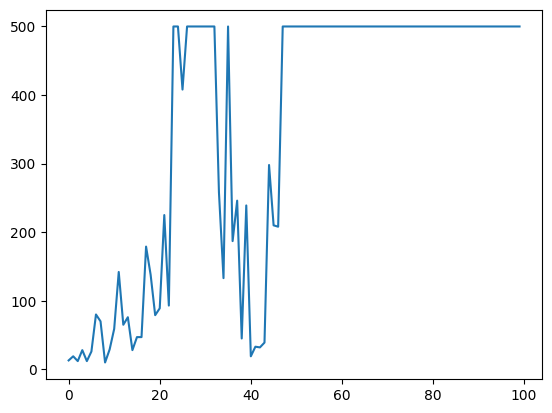

In [259]:
plt.plot(rewards)

# Determine mean rewards

In [262]:
rewards = []
for i in range(100):
  observation = env.reset()
  done = False
  observed_reward = 0
  while not done:
    observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
    action = np.argmax(Q[observation])
    observation, reward, done, info = env.step(action)
    observed_reward += reward
  rewards.append(observed_reward)


NameError: name 'mean' is not defined

In [265]:
np.mean(rewards)

500.0

# Video

In [260]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
i = 0
while True:
    i += 1
    env.render()
    #your agent goes here
    observation = tuple(map(lambda x : bin_index(x[1], x[0], bins[x[0]]), enumerate(observation)))
    action =  np.argmax(Q[observation])
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
